In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive

MyDrive  Shareddrives


In [ ]:
import os

os.chdir("/content/drive/MyDrive/#MIT-Lab/mask_rcnn/Mask_RCNN-master/")
!pwd

/content/drive/MyDrive/#MIT-Lab/mask_rcnn/Mask_RCNN-master


In [ ]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import cv2
import time
import glob
import argparse
from mrcnn.config import Config
from datetime import datetime
#from scipy.misc import imsave
%tensorflow_version 1.x
import tensorflow as tf

TensorFlow 1.x selected.


In [ ]:
# Root directory of the project
ROOT_DIR = '/content/drive/MyDrive/#MIT-Lab/mask_rcnn/Mask_RCNN-master'
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
#sys.path.append(os.path.join(ROOT_DIR, "/samples/coco/"))  # To find local version
#from samples.coco import coco
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

COCO_MODEL_PATH = os.path.join(ROOT_DIR,'mask_rcnn_coco.h5')
# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR,'images')


Using TensorFlow backend.


In [ ]:

class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "coco"
 
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
 
    # Number of classes (including background)
    NUM_CLASSES = 81  # background + 1 shapes + 1 not_defined
 
    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 800
    IMAGE_MAX_DIM = 1024
 
    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)  # anchor side in pixels
 
    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE =200
 
    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 1000
 
    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 50

    # Non-maximum suppression threshold for detection
    #DETECTION_NMS_THRESHOLD = 0.3
##########################################################################
#import train_tongue
#class InferenceConfig(coco.CocoConfig):
class InferenceConfig(ShapesConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
 
config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [ ]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead

Instructions for updating:
Use `tf.cast` instead.


In [ ]:
!pip list

Package                       Version       
----------------------------- --------------
absl-py                       0.10.0        
alabaster                     0.7.12        
albumentations                0.1.12        
altair                        4.1.0         
appdirs                       1.4.4         
argon2-cffi                   20.1.0        
asgiref                       3.3.1         
astor                         0.8.1         
astropy                       4.2           
astunparse                    1.6.3         
async-generator               1.10          
atari-py                      0.2.6         
atomicwrites                  1.4.0         
attrs                         20.3.0        
audioread                     2.1.9         
autograd                      1.3           
Babel                         2.9.0         
backcall                      0.2.0         
backports.tempfile            1.0           
backports.weakref             1.0.post1     
beautifuls

In [ ]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

Processing 1 images
image                    shape: (424, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


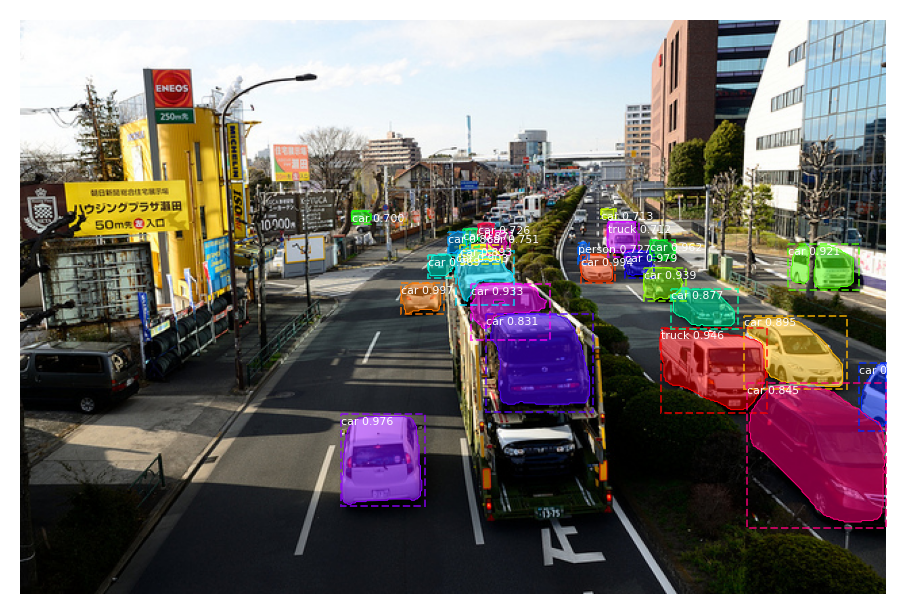

In [ ]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])